In [19]:
import spacy
import timeit
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
from collections import Counter
from lxml import etree
from glob import glob
from unicodedata import normalize
import unidecode
from termcolor import colored
import joblib
from nltk import ngrams
from tqdm.notebook import tqdm

In [3]:
path_name = r'../data/txt_test/*.txt'

In [4]:
MOTIFS_sentences =  joblib.load('/home/crazyjeannot/Documents/doctorat/dev/AWARDS/data/MOTIFS_AWARDS.pkl')
chapitres_index_sentences = joblib.load('/home/crazyjeannot/Documents/doctorat/data/data_chapitres/lemmatizers/fall_pass/main_list_index_stanza_sentences_chapitres.pkl')

In [22]:
best_coefs = pd.read_csv(r'../outputs/BEST_MOTIFS_COEFS.csv', index_col='Unnamed: 0')
best_coefs = best_coefs.T
best_coefs.rename(columns={0: 'coefs'}, inplace=True)
best_coefs.sort_values(by=['coefs'], ascending=False, inplace=True)

In [29]:
non_AWARD = best_coefs[:200]
AWARD = best_coefs[-200:]

In [30]:
selected_coefs = pd.concat([non_AWARD, AWARD], axis=0)

In [7]:
def clean_text(txt):
    txt_res = normalize("NFKD", txt).replace('\xa0', ' ')
    txt_res = txt_res.replace("\\", "").replace('\\xa0', '')
    return txt_res

In [8]:
def rolling_group_sentences(sentences, group_size, overlap):
    grouped_sentences = [sentences[i:i + group_size] for i in range(0, len(sentences) - overlap + 1, overlap)]
    return grouped_sentences

In [9]:
def ngram_list(sentences, n_gram_len):
    # Flatten the list of sentences and split into words
    words = [word for sentence in sentences for word in sentence.split()]
    # Generate n-grams
    n_grams = ngrams(words, n_gram_len)
    return n_grams

In [10]:
def generate_n_grams_dico(n):
    dico_list_ngrams = {}
    for i in range(1, n+1):
        list_name = f"list_{i}_gram"
        dico_list_ngrams[list_name]=[]

    return dico_list_ngrams

In [11]:
def get_ngrams(chunk, len_ngrams=5):
    DICT_TEMP = generate_n_grams_dico(len_ngrams)#key = "list_{i}_gram" avec list vide   
    
    for i in range(1, len_ngrams+1):
            DICT_TEMP[f"list_{i}_gram"].extend(ngram_list(chunk, i))# too big for memory ?
            
    return DICT_TEMP

In [28]:
def signal_canon(path_name, list_index, list_motifs, df_coef, len_ngrams=5, group_size=100, overlap=10):
    
    df_main = pd.DataFrame()

    for doc in glob(path_name):
        
        doc_name = path.splitext(path.basename(doc))[0]
        print(doc_name)
        if doc_name in list_index:
            index_of_element = list_index.index(doc_name)
            list_chunks = rolling_group_sentences(list_motifs[index_of_element], group_size, overlap)
          
            list_scores = compute_score(list_chunks, df_coef, len_ngrams)
            print(pd.Series(list_scores).mean())
            df_main[doc_name] = pd.Series(list_scores)
        else:
            pass
    
    return df_main.fillna(0)

In [13]:
def compute_score(list_chunks, df_coef, len_ngrams):
    list_scores = []
    for chunk in tqdm(list_chunks):
        score = 0
        DICT_NGRAMS = get_ngrams(chunk, len_ngrams)
        
        for i in range(1, len_ngrams+1):
            list_courante = DICT_NGRAMS[f"list_{i}_gram"]
            for ngram in list_courante:
                ngram_str = '_'.join(ngram)
                if ngram_str in list(df_coef.index):
                    temp_score = df_coef.loc[df_coef.index == ngram_str]
                    score += temp_score.values[0][0]
        list_scores.append(score)
    return list_scores

In [32]:
df_test = signal_canon(path_name, chapitres_index_sentences, MOTIFS_sentences, selected_coefs)

1942_Simenon-Georges_Cecile-est-morte


  0%|          | 0/157 [00:00<?, ?it/s]

0.2347254833220573
1904_Rolland-Romain_Jean-Christophe_Tome-I-L-aube


  0%|          | 0/243 [00:00<?, ?it/s]

-0.12985169807933797
1932_Celine-Louis-Ferdinand_Voyage-au-bout-de-la-nuit


  0%|          | 0/804 [00:00<?, ?it/s]

-0.0008856486121822754
1942_Veuzit-Max-du_Moineau-en-cage


  0%|          | 0/367 [00:00<?, ?it/s]

0.21093922602647186


In [25]:
df_scores = signal_canon(path_name, chapitres_index_sentences, MOTIFS_sentences, selected_coefs)

  0%|          | 0/157 [00:00<?, ?it/s]

0.1745392469790479


  0%|          | 0/243 [00:00<?, ?it/s]

-0.0411045982098447


  0%|          | 0/804 [00:00<?, ?it/s]

0.014416254751941375


  0%|          | 0/367 [00:00<?, ?it/s]

0.19327286463422194


In [37]:
df_scores = signal_canon(path_name, chapitres_index_sentences, MOTIFS_sentences, selected_coefs)

2000_Quignard-Pascal_Terrasse-a-Rome


  0%|          | 0/127 [00:00<?, ?it/s]

-0.1218432177779223
1968_Yourcenar-Marguerite_L-Oeuvre-Au-Noir


  0%|          | 0/511 [00:00<?, ?it/s]

-0.2097199087511508
1958_Kessel-Joseph_Le-lion


  0%|          | 0/374 [00:00<?, ?it/s]

0.03700513477612415


In [31]:
df_scores

,1942_Simenon-Georges_Cecile-est-morte,1904_Rolland-Romain_Jean-Christophe_Tome-I-L-aube,1932_Celine-Louis-Ferdinand_Voyage-au-bout-de-la-nuit,1942_Veuzit-Max-du_Moineau-en-cage
0,0.072229,0.072842,0.124418,0.147580
1,0.094773,0.081116,0.062347,0.170364
2,0.055040,0.115571,0.056965,0.100757
3,0.001264,0.114080,0.120050,0.128399
4,0.021073,0.032253,-0.001806,0.186590
...,...,...,...,...
152,0.276845,-0.130584,0.108483,0.280700
153,0.122479,-0.130551,0.079895,0.240994
154,0.104514,-0.132410,0.096959,0.190152
155,0.108131,-0.131036,0.112662,0.232159


In [36]:
def plot_signal(df):
    plt.figure(figsize=(9,6))
    ax = plt.subplot()
    #ax.set_title('Award Signal in our novels')

    ax = sns.lineplot(data=df)

    #sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), fontsize = 20)

    ax.set_xlabel('Morceaux roulants des romans')
    ax.set_ylabel('Score')

    plt.savefig('../img/SIGNAL_viz_kessel.png', format='png', bbox_inches='tight', dpi=400)

    plt.show()

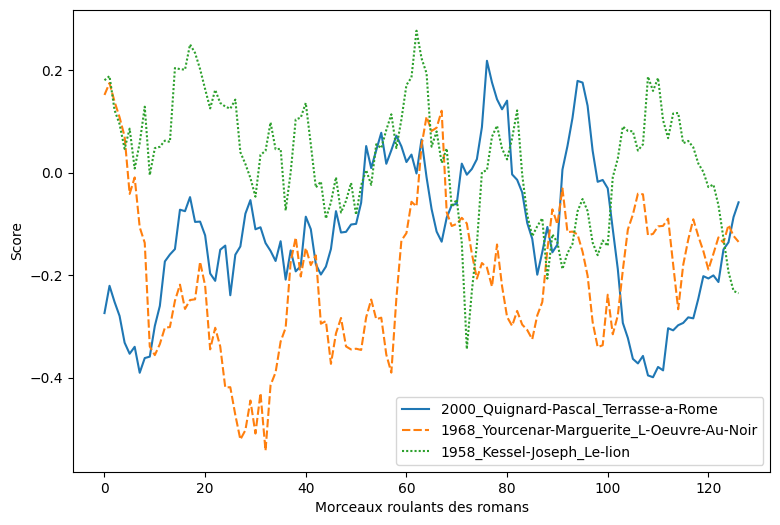

In [38]:
plot_signal(df_scores)

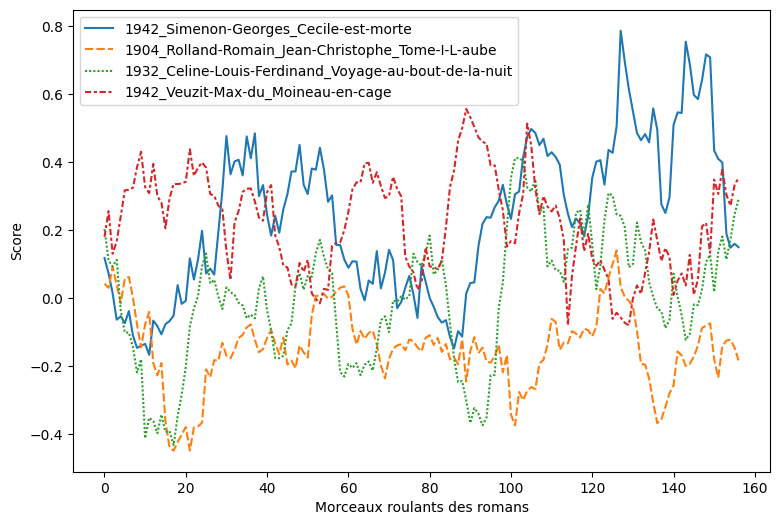

In [35]:
plot_signal(df_test)

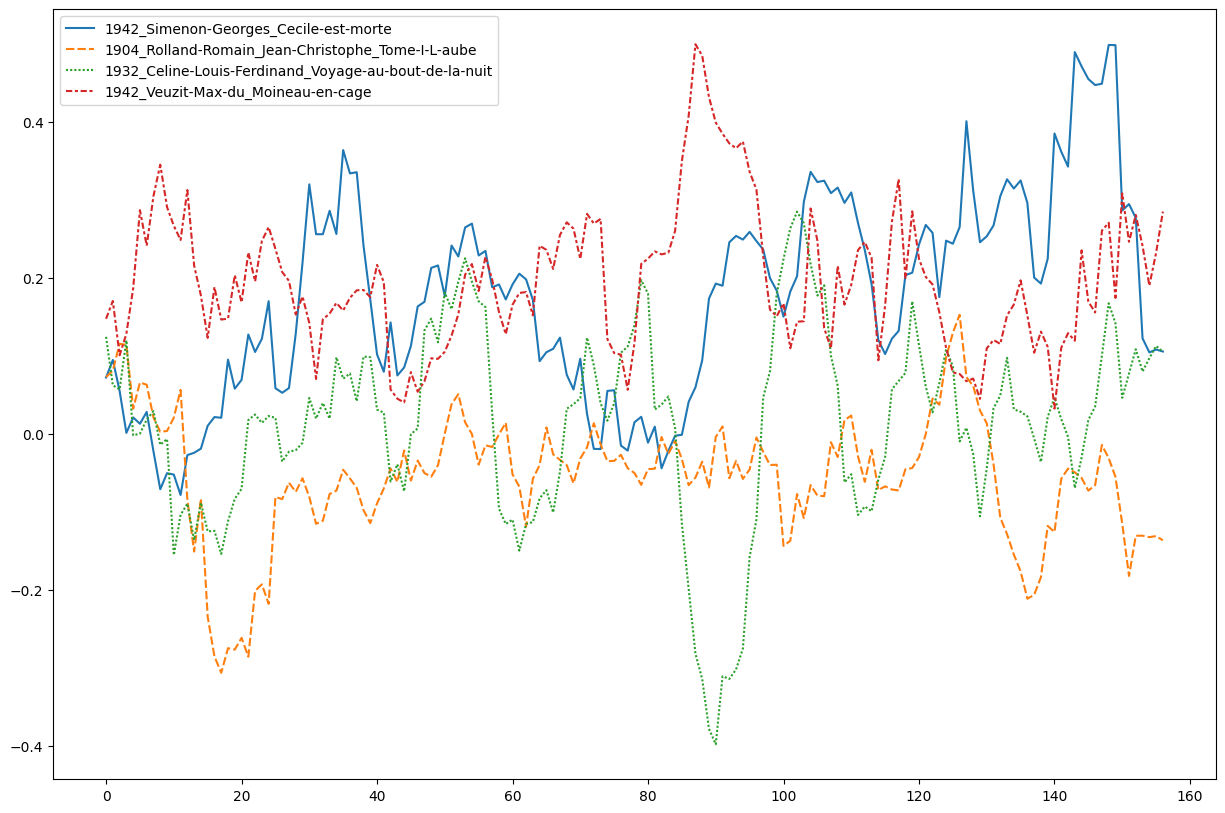

In [27]:
plt.figure(figsize=(15,10))
ax = sns.lineplot(data=df_scores)

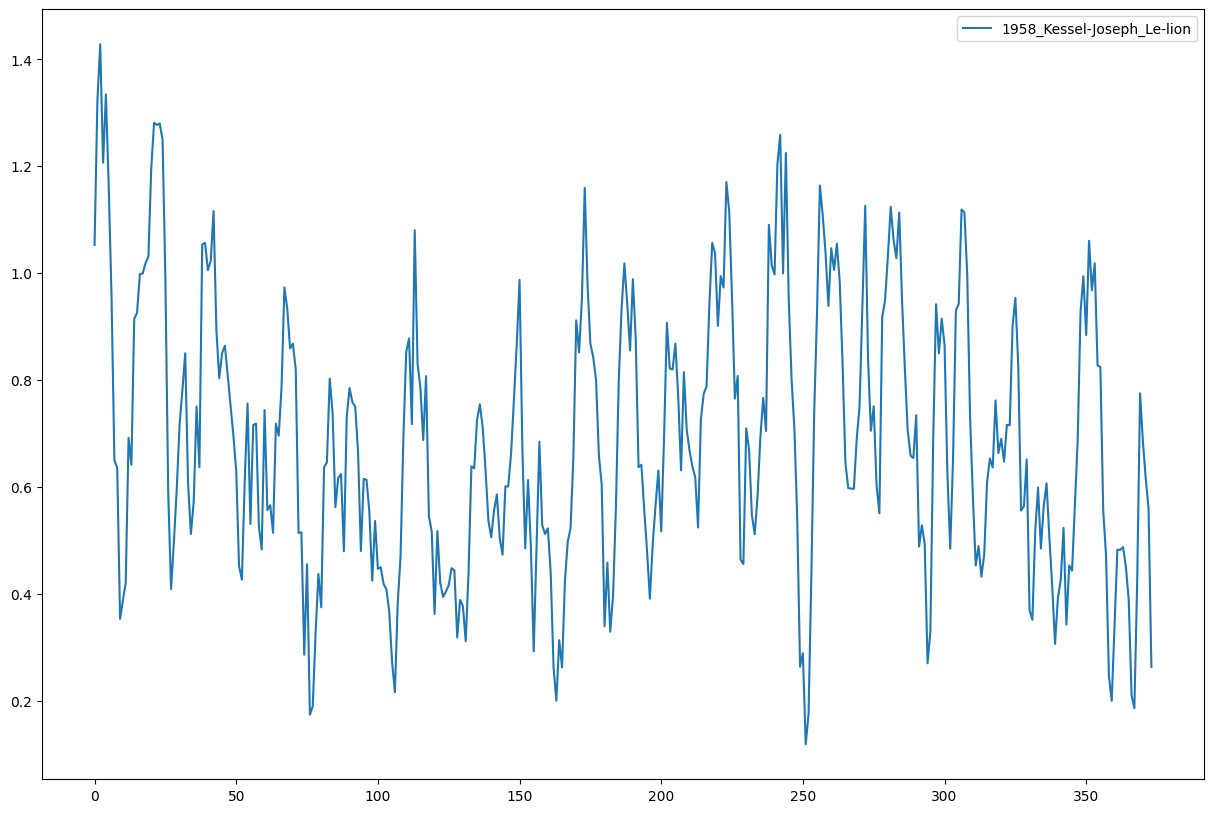

In [78]:
plt.figure(figsize=(15,10))
ax = sns.lineplot(data=df_scores)

In [ ]:
def get_chunk_n(path, n, passage_n):
    score = 0
    list_token = []
    str_base = ' '
    
    with open(path, encoding="utf8") as file:
        txt_brut = file.readlines()
        txt_str = str_base.join(txt_brut)
        txt_cleaned = clean_text(txt_str.lower())
    docs = nlp(txt_cleaned)
    for token in docs:
        list_token.append(token.text)
    list_chunks = chunkise(list_token, n)
    
    return str_base.join(list_chunks[passage_n])

In [ ]:
path_name = r'corpus_test/1884_Huysmans-Joris-Karl_a-rebours.txt'

In [ ]:
get_chunk_n(path_name, 500, 80)